In [2]:
from collections import defaultdict as ddict
from __future__ import division
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import pprint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


dictionary initialization done <HDF5 file "mouse8284_sess1_D2016_12_14T15_51_57.h5" (mode r)>
dictionary initialization done <HDF5 file "mouse8284_sess1_D2016_12_14T16_19_59.h5" (mode r)>
dictionary initialization done <HDF5 file "mouse8284_sess1_D2016_12_14T16_32_33.h5" (mode r)>
dictionary initialization done <HDF5 file "mouse8284_sess1_D2016_12_14T16_46_45.h5" (mode r)>
dictionary initialization done <HDF5 file "mouse8284_sess1_D2016_12_14T16_59_9.h5" (mode r)>
dictionary initialization done <HDF5 file "mouse8284_sess1_D2016_12_14T16_6_51.h5" (mode r)>


PERFORMANCE
{1: {'(+)-carvone': {'(+)-limonene': array([[[ 24.,  32.,  75.,   0.]]]),
                     '(-)-limonene': array([[[ 23.   ,  33.   ,  71.875,   1.   ]]]),
                     'None': array([[[ 94.        ,  99.        ,  95.91836735,   1.        ]]])},
     '(-)-carvone': {'(+)-limonene': array([[[ 23.        ,  41.        ,  56.09756098,   0.        ]]]),
                     '(-)-limonene': array([[[ 37. ,  41. ,

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:128: RuntimeWarning: invalid value encountered in true_divide


<matplotlib.colorbar.Colorbar instance at 0x10e0be2d8>

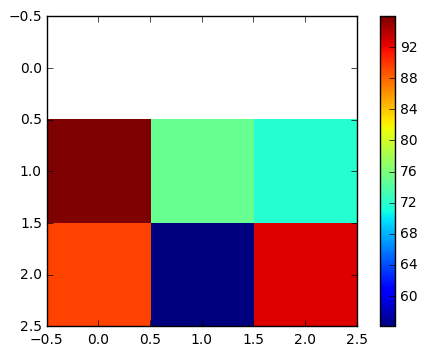

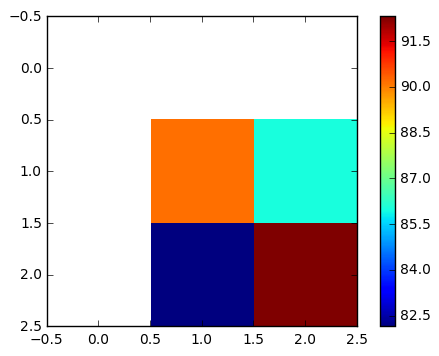

In [111]:
class Session:
    
    def __init__(self, data):
        
        self.data = data
        self.trialsdataset = self.data['Trials']
        self.trials = self.trialsdataset['trialNumber']
        self.numtrials = len(self.trials)
        self.results = self.trialsdataset['result']
        self.proportion_correct = 0
        self.hits = 0
        self.misses = 0
        self.rewards = []
        self.pc = self.calculate_percent_correct()
        
        self.flows0 = self.trialsdataset['olfas:olfa_0:mfc_1_flow']
        self.flows1 = self.trialsdataset['olfas:olfa_1:mfc_1_flow']
        
        self.odors0 = self.trialsdataset['olfas:olfa_0:odor']
        self.odors1 = self.trialsdataset['olfas:olfa_1:odor']
        
#         try:
#             self.odors0 = self.trialsdataset['olfas:olfa_0:odor']
#             self.odors1 = self.trialsdataset['olfas:olfa_1:odor']
#         except AttributeError:
#             pass
    
        self.context = self.trialsdataset['context']
        
        self.concmatdict = {1:{}, 2:{}}
        
        for key in self.concmatdict.keys():
            carvonedict = {"None":{}, '(+)-carvone':{}, '(-)-carvone':{}}
            for carkey in carvonedict.keys():
                limonenedict = {"None":[], '(+)-limonene':[], '(-)-limonene':[]}
                carvonedict[carkey] = limonenedict
            self.concmatdict[key] = carvonedict
                    
        self.concmatdict = self.make_concentration_bins()
        print 'dictionary initialization done', data
        return

        
    def calculate_percent_correct(self):
        for i in xrange(len(self.results)):
            if self.results[i] == 1 or self.results[i]==2:
                self.rewards.append(1)
                self.hits +=1
            else:
                self.rewards.append(0)
            if self.results[i] > 4:
                self.misses +=1
            
        self.proportion_correct = self.hits/(self.numtrials-self.misses)
        self.pc = 100*self.proportion_correct
        return self.pc
    
#     def make_mixture_array(self):
#         for trial in range(self.numtrials):
            

    def make_concentration_bins(self):
        carvoneflows = np.unique(self.flows0)
        # find unique concentration values, one dimension of the matrix will be defined by this number
        # instead of using flows, define a concentration variable in init function
        # where it takes into account nitrogen flow and vial concentration
        # so this will all be done in terms of molarity, not flow
        limoneneflows =np.unique(self.flows1)
        contextlist = [1, 2]
        #contextlist = np.unique(self.context)
        #print contextlist
        carvonelist = ['(+)-carvone', 'None', '(-)-carvone']
        limonenelist = ['(+)-limonene', 'None', '(-)-limonene']
        
#         for trial in range(self.numtrials):
#             if self.odors0[trial] == 'None':
#                 self.flows0[trial] = 0
#             if self.odors1[trial] == 'None':
#                 self.flows1[trial] = 0
        
        for cont, key in zip(contextlist,self.concmatdict.keys()):
            for carv, carvkey in zip(carvonelist, self.concmatdict[key].keys()):
                for lim, limkey in zip(limonenelist, self.concmatdict[key][carvkey].keys()):

                    concmat = np.zeros((len(carvoneflows), len(limoneneflows), 4)) # first dimension is hits, second num trials, third percent correct, fourth misses

                    for i in range(len(carvoneflows)):
                        carcon = carvoneflows[i]
                        for j in range(len(limoneneflows)):
                            limcon = limoneneflows[j]

                            for trial in range(self.numtrials):

                                if self.context[trial] == cont and self.odors0[trial] == carv and self.odors1[trial] == lim \
                                and self.flows0[trial] == carcon and self.flows1[trial] == limcon:


                                    concmat[i][j][1] += 1
                                    if self.rewards[trial] == 1:
                                        concmat[i][j][0] += 1
                                    if self.results[trial] > 4:
                                        concmat[i][j][3] +=1

                    for a in range(len(carvoneflows)):
                        for b in range(len(limoneneflows)):
                            if concmat[a][b][1]:
                                concmat[a][b][2] = 100.*float( concmat[a][b][0]) / float( concmat[a][b][1] - concmat[a][b][3])

                            else:

                                concmat[a][b][2] = 0


                    self.concmatdict[key][carvkey][limkey] = concmat
        return self.concmatdict

def overall_performance(instances): # hits, misses, percent correct, etc from all trials of same odorset
    overall_dict = {1:{}, 2:{}}
    for instance in instances:
        for key in instance.concmatdict.keys():
            for key2 in instance.concmatdict[key].keys():
                if key2 in overall_dict[key].keys():
                    for key3 in instance.concmatdict[key][key2].keys():
                        if key3 in overall_dict[key][key2]:

                            for mat in instance.concmatdict[key][key2][key3]:

                                overall_dict[key][key2][key3] += instance.concmatdict[key][key2][key3]
                                overall_dict[key][key2][key3][:,:,2] = \
                                100*overall_dict[key][key2][key3][:,:,0]/(overall_dict[key][key2][key3][:,:,1]-\
                                overall_dict[key][key2][key3][:,:,3])
                                    # need to take the mean of the third index of the matrix
#                                     else:
#                                         overall_dict[key][key2][key3] = np.zeros((len(np.unique(instance.flows0)), len(np.unique(instance.flows1)), 4))

                        else:
                            overall_dict[key][key2] = {}
                            overall_dict[key][key2] = instance.concmatdict[key][key2][key3]
                else:
                    overall_dict[key] = {}
                    overall_dict[key] = instance.concmatdict[key]
    return overall_dict

dirpath='/Users/angiepickens/Desktop/mouse_8284'
dirs = os.listdir(dirpath)
session_instances = []
for i, file in zip(range(len(dirs)), dirs):
    if file.endswith('.h5'):
        data = h5py.File(dirpath+'/'+file,'r')
        instance = Session(data)
        session_instances.append(instance)

performance = overall_performance(session_instances)
print ''
print ''
print 'PERFORMANCE'
pprint.pprint( performance)

matrix = np.zeros((3,3))

for i, key in zip (range(len(performance[1].keys())), performance[1].keys()):
    for j, key2 in zip(range(len(performance[1][key].keys())),performance[1][key].keys()):
        matrix[i, j] = performance[1][key][key2][:,:,2]

matrixa = np.zeros((3,3))
matrixa[0, :] = matrix[1,:]
matrixa[1, :] = matrix[0, :]
matrixa[2, :] = matrix[2, :]

matrixa1 = np.zeros((3,3))
matrixa1[:, 0] = matrixa[:,1]
matrixa1[:,1] = matrixa[:,0]
matrixa1[:,2] = matrixa[:,2]

print matrixa
print matrixa1

matrixb = np.zeros((3,3))
for i, key in zip (range(len(performance[2].keys())), performance[2].keys()):
    for j, key2 in zip(range(len(performance[2][key].keys())),performance[2][key].keys()):
        matrixb[i, j] = performance[2][key][key2][:,:,2]

matrixb1 = np.zeros((3,3))
matrixb1[0, :] = matrixb[1,:]
matrixb1[1, :] = matrixb[0, :]
matrixb1[2, :] = matrixb[2, :]

matrixb2 = np.zeros((3,3))
matrixb2[:, 0] = matrixb1[:,1]
matrixb2[:,1] = matrixb1[:,0]
matrixb2[:,2] = matrixb1[:,2]

print matrixb
print matrixb2

plt.figure()
img = plt.imshow(matrixa1,interpolation='nearest')
plt.colorbar(img)

plt.figure()
img2 = plt.imshow(matrixb2,interpolation='nearest')
plt.colorbar(img2)

#have a counter with a separate dictionary for number of trials, hits, misses, etc for each
#combination of odorants and concentrations
#then take the 3D matrices from each instance and average the third value, put this into a 2D matrix

In [22]:
# create performance plots per day/session for each context
# does this need to be a separate thing?

class Performance:

def __init__(self, data):
    
    
    
def calculate_pc(self): # instead of calculating points for each day, make a sliding window of ~100 trials
                        # and calculate performance for each window
                        # so maybe this doesn't need to be in a class since we'll want to pull out trials for each context
                        # and make a huge array of all the trials, then run a window over it and calculate performance
                        # for each window
                        # but that is also a dumb idea
    for day in days: # calculate point for each day
        for cont in contextlist:
            for i in numtrials: # find the trials that are in a certain context
                if context[i] == cont:
                    #calculate percent correct
                else:
                    pass

performance = []
sessioncounter = []

def create_performance_array(instance):
    for session in sessions:
        performance.append(instance.percentcorrect)
        sessioncounter.append([1]) # do this for each day, not each file?
        
    
# then take instances of each session and plot them vs number of sessions

IndentationError: expected an indented block (<ipython-input-22-ed66f770feec>, line 6)

In [ ]:
x=h5py.File(file,'r')
x

In [ ]:
dirpath='/Users/angiepickens/Desktop/mouse_8284'
dirs = os.listdir(dirpath)
x=h5py.File(dirpath+'/'+dirs[1],'r')
